In [38]:
#Loading required libraries
import os
import math
import scipy
import numpy as np
import pandas as pd
import datetime as dt
import geopy.distance
import shap
from IPython.display import display

from statsmodels.formula import api
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings 
warnings.filterwarnings('ignore')

In [39]:
#Reading file
train_df = pd.read_csv("uber.csv")
print(train_df.shape)
print(train_df.columns)

(200000, 9)
Index(['Index', 'key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')


In [40]:
#Converting pickup datatime column into actual format
train_df["pickup_datetime"]=pd.to_datetime(train_df['pickup_datetime'])

In [41]:
#First few rows of the data
train_df.head()

,Index,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,35242813,09:47.0,22.5,2015-01-01 00:09:47+00:00,-73.990059,40.757221,-73.999512,40.723217,1
1,27835199,04:56.0,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,45:00.0,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,22:21.0,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,47:00.0,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5


In [42]:
#Basic Stats about the data
train_df.describe()

,Index,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+05,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,2.771250e+07,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,1.601382e+07,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,1.000000e+00,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,1.382535e+07,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,2.774550e+07,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,4.155530e+07,12.500000,-73.967153,40.767158,-73.963659,40.768001,2.000000
max,5.542357e+07,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


In [43]:
#Removing records with NA Values
train_df.dropna(inplace=True)
print(train_df.isnull().sum())

Index                0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


In [44]:
#Outlier constraints
min_longitude=-74.263242,
min_latitude=40.573143,
max_longitude=-72.986532, 
max_latitude=41.709555

In [45]:
#Removing outliers
tempdf=train_df[(train_df["dropoff_latitude"]<min_latitude) | (train_df["pickup_latitude"]<min_latitude) | (train_df["dropoff_longitude"]<min_longitude) | (train_df["pickup_longitude"]<min_longitude) | (train_df["dropoff_latitude"]>max_latitude) | (train_df["pickup_latitude"]>max_latitude) | (train_df["dropoff_longitude"]>max_longitude) | (train_df["pickup_longitude"]>max_longitude) ]
print("before droping",train_df.shape)
train_df.drop(tempdf.index,inplace=True)
print("after droping",train_df.shape)

before droping (199999, 9)
after droping (195560, 9)


In [46]:
#Feature Engineering
import calendar
train_df['day']=train_df['pickup_datetime'].apply(lambda x:x.day)
train_df['hour']=train_df['pickup_datetime'].apply(lambda x:x.hour)
train_df['weekday']=train_df['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
train_df['month']=train_df['pickup_datetime'].apply(lambda x:x.month)
train_df['year']=train_df['pickup_datetime'].apply(lambda x:x.year)
train_df = train_df[train_df['year'] == 2015]

In [47]:
#Showing first few rows
train_df.head()

,Index,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day,hour,weekday,month,year
0,35242813,09:47.0,22.5,2015-01-01 00:09:47+00:00,-73.990059,40.757221,-73.999512,40.723217,1,1,0,Thursday,1,2015
10,51300077,15:31.0,9.5,2015-01-01 00:15:31+00:00,-73.985649,40.747444,-73.988586,40.729805,1,1,0,Thursday,1,2015
18,41247972,20:44.0,6.0,2015-01-01 00:20:44+00:00,-73.995056,40.765320,-73.974457,40.753860,1,1,0,Thursday,1,2015
21,41138301,47:06.0,5.5,2015-01-01 00:47:06+00:00,-74.002419,40.733700,-73.987282,40.720634,2,1,0,Thursday,1,2015
47,13349674,51:07.0,6.0,2015-01-01 00:51:07+00:00,-73.985779,40.722897,-73.984879,40.760651,1,1,0,Thursday,1,2015


In [48]:
#Creating weekday mapping
train_df.weekday = train_df.weekday.map({'Sunday':0,'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6})

In [49]:
#Removing data with inconsistent values
train_df=train_df[train_df['passenger_count']<=7]
train_df=train_df[train_df['fare_amount']>0]

In [50]:
#Dropping Irrelevant columns
train_df.drop(["Index","key","pickup_datetime","year"], axis=1, inplace=True)

In [51]:
#Creating Distance column
train_df['pickup_location'] = train_df.apply(lambda x: (x['pickup_latitude'], x['pickup_longitude']), axis=1)

train_df['drop_location'] = train_df.apply(lambda x: (x['dropoff_latitude'], x['dropoff_longitude']), axis=1)

train_df['distance'] = train_df.apply(lambda x: geopy.distance.geodesic(x['pickup_location'], x['drop_location']).km, axis=1)

train_df.drop(["pickup_location","drop_location"], axis=1, inplace=True)

In [52]:
#Basic info about the data
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13351 entries, 0 to 199998
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fare_amount        13351 non-null  float64
 1   pickup_longitude   13351 non-null  float64
 2   pickup_latitude    13351 non-null  float64
 3   dropoff_longitude  13351 non-null  float64
 4   dropoff_latitude   13351 non-null  float64
 5   passenger_count    13351 non-null  int64  
 6   day                13351 non-null  int64  
 7   hour               13351 non-null  int64  
 8   weekday            13351 non-null  int64  
 9   month              13351 non-null  int64  
 10  distance           13351 non-null  float64
dtypes: float64(6), int64(5)
memory usage: 1.2 MB


In [53]:
#Defining Predictor columns
x=train_df.drop("fare_amount", axis=1)

In [54]:
#Defining Target Variable
y=train_df['fare_amount']

In [55]:
#Creating test and train set using 80:20 split
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=101)

In [56]:
#First Few rows of train set of predictors
x_train.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day,hour,weekday,month,distance
57462,-73.973343,40.792721,-74.008530,40.719719,1,24,7,2,2,8.634173
12056,-73.864281,40.769569,-73.977478,40.750504,1,13,13,2,1,9.790021
38065,-73.973885,40.764084,-73.968063,40.762302,1,7,19,6,2,0.529837
6257,-73.954857,40.777737,-73.987579,40.738724,2,8,15,4,1,5.138509
10972,-74.000809,40.724030,-74.000870,40.723915,1,12,19,1,1,0.013715


In [57]:
#First Few rows of test set of predictors
x_test.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day,hour,weekday,month,distance
131209,-73.981514,40.774437,-73.976227,40.755653,1,29,17,3,4,2.133138
194574,-73.993233,40.727646,-73.965172,40.772602,2,25,18,4,6,5.526254
120183,-73.979279,40.776829,-73.962761,40.804268,1,20,11,1,4,3.350881
139694,-73.990952,40.749432,-74.009483,40.724342,1,6,6,3,5,3.195761
24176,-73.981346,40.774036,-73.970680,40.764038,1,24,16,6,1,1.429576


In [58]:
#Lets see with Random Forest and calculate its rmse
from sklearn.ensemble import RandomForestRegressor
rfrmodel = RandomForestRegressor(n_estimators=100, random_state=101, max_depth = 60, max_features = "sqrt", bootstrap = True, min_samples_leaf = 4, min_samples_split = 10)
#, max_depth = 60, max_features = 'auto', bootstrap = True, min_samples_leaf = 4, min_samples_split = 10

In [59]:
# rfrmodel.fit(x_train,y_train)

In [60]:
#Running Gridsearch to identify best parameter values
from sklearn.model_selection import GridSearchCV

# rfrmodel.fit(x_train,y_train)
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(50, 110, num = 11)]
# max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

grid_param = { 'max_features': max_features,
#                'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
              
grid = GridSearchCV(rfrmodel,grid_param,cv = 5, scoring = 'neg_root_mean_squared_error')
grid.fit(x_train,y_train)
#best parameter combination
grid.best_params_

#Score achieved with best parameter combination
grid.best_score_

#all combinations of hyperparameters
grid.cv_results_['params']

#average scores of cross-validation
grid.cv_results_['mean_test_score']

array([ -9.31815913,  -9.29054708,  -9.24831454,  -9.24932626,
        -9.24548575,  -9.21645029,  -9.19277652,  -9.19277652,
        -9.18794022,  -9.24698116,  -9.21040783,  -9.18656007,
        -9.18575911,  -9.17676152,  -9.12838682,  -9.11907753,
        -9.11907753,  -9.1190132 , -12.34045924, -12.15231953,
       -11.59360812, -12.07259606, -12.00565644, -11.41984531,
       -11.13602534, -11.13602534, -10.9986086 ,  -9.37616904,
        -9.32866788,  -9.2770724 ,  -9.28911088,  -9.27412371,
        -9.24551685,  -9.20894458,  -9.20894458,  -9.19936761])

In [61]:
#Best Parameter values based on gridsearch 
grid.best_params_

{'bootstrap': True,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 10}

In [62]:
#Prediction on test data
rfrmodel_pred= grid.predict(x_test)

In [63]:
#RMSE of the model on test data
rfrmodel_rmse=np.sqrt(mean_squared_error(y_test,rfrmodel_pred))
print("RMSE value ",rfrmodel_rmse)

RMSE value  9.917962472305248


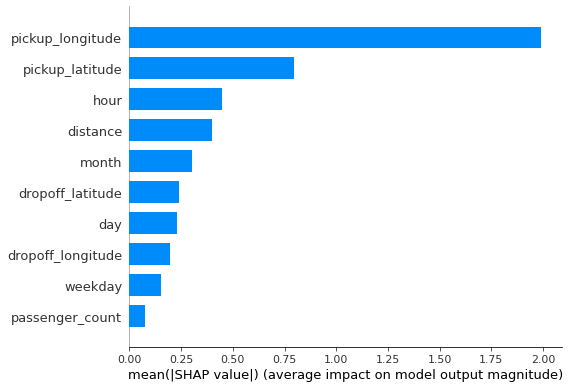

In [64]:
#Running Shap Alogrithm to get feature importance from Random Forest
explainer = shap.TreeExplainer(grid.best_estimator_)
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values, x_test, plot_type="bar")

In [65]:
#Getting first few rows of the data
train_df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day,hour,weekday,month,distance
0,22.5,-73.990059,40.757221,-73.999512,40.723217,1,1,0,4,1,3.859617
10,9.5,-73.985649,40.747444,-73.988586,40.729805,1,1,0,4,1,1.974459
18,6.0,-73.995056,40.765320,-73.974457,40.753860,1,1,0,4,1,2.155214
21,5.5,-74.002419,40.733700,-73.987282,40.720634,2,1,0,4,1,1.933992
47,6.0,-73.985779,40.722897,-73.984879,40.760651,1,1,0,4,1,4.193236


In [66]:
#Creating copy of the data
train_df_copy = train_df.copy()

In [67]:
#Dropping some columns which will not be required for K-Means
train_df_copy.drop(["pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude","day","hour","weekday","month"], axis=1, inplace=True)

In [68]:
#Scaling Variables
from sklearn import preprocessing

train_df_copy_values = train_df_copy.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(train_df_copy_values)
train_df_copy_scaled = pd.DataFrame(x_scaled,
columns=train_df_copy.columns)

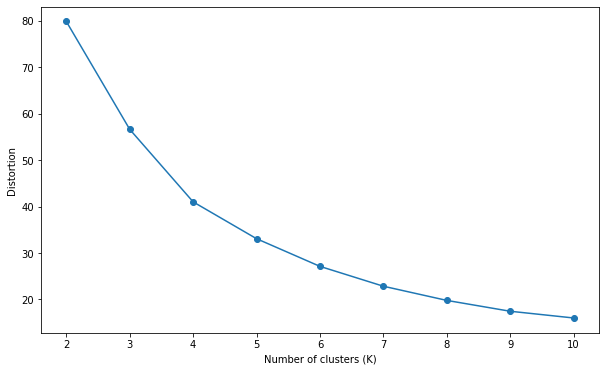

In [77]:
#Create Elbow curve to identify k for K-Means
from sklearn.cluster import KMeans
distortions = []
X=train_df_copy_scaled.iloc[:, [0,2]].values
for k in range(2, 11):
    KMeans_model = KMeans(n_clusters=k, random_state=42)
    KMeans_model.fit(X)
    distortions.append(KMeans_model.inertia_)

plt.plot(range(2, 11), distortions,  marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Distortion')
plt.savefig('elbow plot.png')

In [78]:
#Running K-Means
model = KMeans(n_clusters=4, random_state=42)
model.fit(X)

centroids = model.cluster_centers_
centroids

array([[0.05503226, 0.15913108],
       [0.05267567, 0.05321196],
       [0.21451011, 0.11801511],
       [0.17277024, 0.40948021]])

In [79]:
#Adding clusters to original dataset
train_df['Clusters'] = model.labels_.tolist()

In [80]:
#Identifying insights from the clusters
grouped_multiple = train_df.groupby(['Clusters']).agg({'fare_amount': ['mean','min','max'],
                                                 'distance': ['mean','min','max']})

grouped_multiple = grouped_multiple.reset_index()
grouped_multiple.columns = list(map("_".join, grouped_multiple.columns))
grouped_multiple["ratio_fare_by_distance"] = (
    grouped_multiple["fare_amount_mean"] / grouped_multiple["distance_mean"]
)

grouped_multiple

,Clusters_,fare_amount_mean,fare_amount_min,fare_amount_max,distance_mean,distance_min,distance_max,ratio_fare_by_distance
0,0,10.517862,0.01,31.00,7.767493,5.146890,16.038850,1.354087
1,1,10.064364,2.50,31.00,2.606836,0.013715,5.216777,3.860759
2,2,40.999157,25.00,120.08,5.773322,0.038101,13.298081,7.101485
3,3,32.978018,2.50,190.83,19.976126,12.831717,48.764329,1.650872


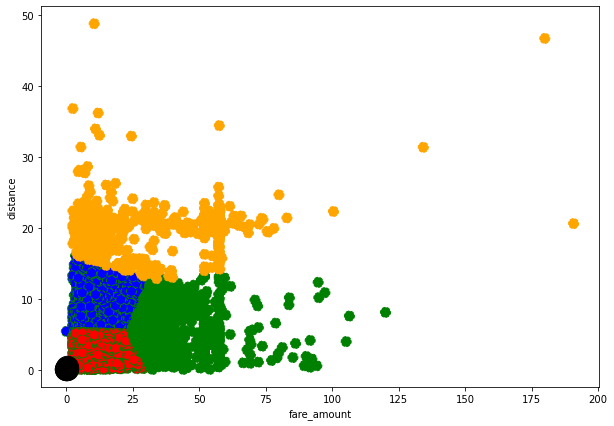

In [87]:
#Plotting clusters on a scatter plot betwwen distance and fare amount
fig, ax = plt.subplots(figsize=(10,7))
plt.scatter(train_df["fare_amount"][train_df["Clusters"] == 0], train_df["distance"][train_df["Clusters"] == 0], 
            color = "blue", s=100, edgecolor='green',linestyle='--')
plt.scatter(train_df["fare_amount"][train_df["Clusters"] == 1], train_df["distance"][train_df["Clusters"] == 1], 
            color = "red", s=100, edgecolor='green',linestyle='--')
plt.scatter(train_df["fare_amount"][train_df["Clusters"] == 2], train_df["distance"][train_df["Clusters"] == 2], 
            color = "green", s=100, edgecolor='green',linestyle='--')
plt.scatter(train_df["fare_amount"][train_df["Clusters"] == 3], train_df["distance"][train_df["Clusters"] == 3], 
            color = "orange", s=100, edgecolor='orange',linestyle='--')
centers = model.cluster_centers_
# plt.scatter(centers[:, 0], centers[:, 1], c='black', s=500);
ax.set_xlabel('fare_amount')
ax.set_ylabel('distance')
plt.show()

In [45]:
#Saving final file to local system which has clusters
train_df.to_csv(r'Final_Clusters_Uber v0.1.csv')